In [2]:
import sys

sys.path.insert(0,'/home/mmo-gog/dpsim/build/')
sys.path.insert(0,'/home/mmo-gog/dpsim/python/src/dpsim')

import iaewreader
import dpsimpy

from villas.dataprocessing.timeseries import TimeSeries as ts
import villas.dataprocessing.plottools as pt

from villas.dataprocessing.readtools import *
from villas.dataprocessing.timeseries import *
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
import math

#%matplotlib widget

In [3]:
#Original
path_file = '/home/mmo-gog/dpsim/examples/Notebooks/9BusValidations/Originial_Static_Dynamic_Data_9Bus_System_incl_simulations.mat'
#file from=1, to =4
#path_file = '/home/mmo-gog/dpsim/examples/Notebooks/9BusValidations/Static_Dynamic_Data_9Bus_System.mat'
#File from=4, to =1
#path_file = '/home/mmo-gog/dpsim/examples/Notebooks/9BusValidations/Static_Dynamic_Data_9Bus_System_incl_simulations.mat'

Power Flow Simulation

In [4]:
sim_name_pf = '9Bus_SYN_PF'
dpsimpy.Logger.set_log_dir('logs/' + sim_name_pf)

# read and create dpsim topology
mpc_reader = iaewreader.Reader(mpc_file_path=path_file, mpc_name='case9_static_only_SYN', 
                             mpc_dyn_file_path=path_file, mpc_dyn_name='case9_dyn_only_SYN')
mpc_reader.load_mpc(domain=iaewreader.Domain.PF)
system_pf = mpc_reader.system

# log results
logger = dpsimpy.Logger(sim_name_pf)
for node in system_pf.nodes:
    logger.log_attribute(node.name()+'.V', 'v', node)
    logger.log_attribute(node.name()+'.S', 's', node)

# Parametrize and run simulation
sim_pf = dpsimpy.Simulation(sim_name_pf, dpsimpy.LogLevel.info)
sim_pf.set_system(system_pf)
sim_pf.set_time_step(0.1)
sim_pf.set_final_time(0.1)
sim_pf.set_domain(dpsimpy.Domain.SP)
sim_pf.set_solver(dpsimpy.Solver.NRP)
sim_pf.do_init_from_nodes_and_terminals(False)
sim_pf.set_solver_component_behaviour(dpsimpy.SolverBehaviour.Initialization)
sim_pf.add_logger(logger)
sim_pf.run()

dpsim_result_file = 'logs/' + sim_name_pf + '/' + sim_name_pf + '.csv'
ts_dpsim_pf = read_timeseries_csv(dpsim_result_file)

dpsim_results = pd.DataFrame(columns=['Bus', 'V_mag(pu)', 'V_angle(deg)', 'P(MW)', 'Q(MVAr)'])
base_power = 1 #mw
for i in range(len(system_pf.nodes)):
    node_name = system_pf.nodes[i].name() #ex. N5
    node_number = node_name.replace('N', '')
    node_baseV = mpc_reader.mpc_bus_data.loc[mpc_reader.mpc_bus_data['bus_i'] == int(node_number), 'baseKV'].iloc[0] * 1e3
    w_mw = 1e-6
    dpsim_results.loc[i] = ([node_name] + [round(np.absolute(ts_dpsim_pf[node_name + '.V'].values[-1]) / node_baseV, 3)]
        + [round(np.angle(ts_dpsim_pf[node_name + '.V'].values[-1])*180/np.pi, 3)] 
        + [round(w_mw * np.real(ts_dpsim_pf[node_name + '.S'].values[-1]) / base_power, 3)] 
        + [round(w_mw * np.imag(ts_dpsim_pf[node_name + '.S'].values[-1]) / base_power, 3)])

dpsim_results

   bus  model       BaseS    H    D        Xd        Xq  Xd_t  Xq_t  Xd_s  \
0  1.0    2.0  670.820393  2.0  0.1  1.811215  1.646559   0.3   0.4   0.2   
1  2.0    2.0  500.000000  2.0  0.1  1.811215  1.646559   0.3   0.4   0.2   
2  3.0    2.0  500.000000  2.0  0.1  1.811215  1.646559   0.3   0.4   0.2   

   Xq_s  Td0_t  Tq0_t  Td0_s  Tq0_s   Ra  
0   0.2    7.0    1.5   0.05   0.05  0.0  
1   0.2    7.0    1.5   0.05   0.05  0.0  
2   0.2    7.0    1.5   0.05   0.05  0.0  
   bus  Type     Ka    Te   Ta    Tb  U_min  U_max   Kbc
0  1.0   2.0  200.0  0.05  3.0  10.0   -4.0    4.0  10.0
1  2.0   2.0  200.0  0.05  3.0  10.0   -4.0    4.0  10.0
2  3.0   2.0  200.0  0.05  3.0  10.0   -4.0    4.0  10.0
   bus  Type   Tw    T1    T2    T3     T4    Ks  U_smin  U_smax
0  1.0   1.0  2.0  0.25  0.03  0.15  0.015  10.0    -0.1     0.1
1  2.0   1.0  2.0  0.25  0.03  0.15  0.015  10.0    -0.1     0.1
2  3.0   1.0  2.0  0.25  0.03  0.15  0.015  10.0    -0.1     0.1
   bus  Type    K   T1       T2

[22:49:51.768535 9Bus_SYN_PF info] Initialize simulation: 9Bus_SYN_PF
[22:49:51.768921 9Bus_SYN_PF_PF_Solver warning] Unable to get base voltage at N4
[22:49:51.768927 9Bus_SYN_PF_PF_Solver warning] Unable to get base voltage at N5
[22:49:51.768931 9Bus_SYN_PF_PF_Solver warning] Unable to get base voltage at N6
[22:49:51.768933 9Bus_SYN_PF_PF_Solver warning] Unable to get base voltage at N7
[22:49:51.768936 9Bus_SYN_PF_PF_Solver warning] Unable to get base voltage at N8
[22:49:51.768938 9Bus_SYN_PF_PF_Solver warning] Unable to get base voltage at N9
[22:49:51.768941 9Bus_SYN_PF_PF_Solver warning] Unable to get base voltage at N10
[22:49:51.768944 9Bus_SYN_PF_PF_Solver warning] Unable to get base voltage at N11
[22:49:51.768947 9Bus_SYN_PF_PF_Solver warning] Unable to get base voltage at N12
[22:49:51.769142 9Bus_SYN_PF info] Scheduling tasks.
[22:49:51.769277 9Bus_SYN_PF info] Scheduling done.
[22:49:51.769279 9Bus_SYN_PF info] Opening interfaces.
[22:49:51.769280 9Bus_SYN_PF info] Sta

,Bus,V_mag(pu),V_angle(deg),P(MW),Q(MVAr)
0,N1,1.000,0.000,476.291,221.397
1,N2,0.950,-7.156,120.000,4.748
2,N3,1.000,-7.619,120.000,85.476
3,N4,1.028,-3.164,-0.000,0.000
4,N5,0.977,-9.123,-0.000,0.000
5,N6,0.976,-9.687,-0.000,0.000
6,N7,0.912,-14.770,-0.000,0.000
7,N8,0.949,-9.393,-0.000,0.000
8,N9,0.960,-8.964,-0.000,0.000
9,N10,0.960,-12.708,-200.000,-50.000


SP dynamic simulation and results

In [5]:
sim_name_dyn_sp = 'SP_only_SYN_case9_dyn'
dpsimpy.Logger.set_log_dir('logs/' + sim_name_dyn_sp)

mpc_reader = iaewreader.Reader(mpc_file_path=path_file, mpc_name='case9_static_only_SYN', 
                             mpc_dyn_file_path=path_file, mpc_dyn_name='case9_dyn_only_SYN')
mpc_reader.create_dpsim_objects(domain=iaewreader.Domain.SP, frequency=50, with_avr=True, with_tg=True, with_pss=True)
#create a switch
sw = dpsimpy.sp.ph1.Switch('Fault', dpsimpy.LogLevel.info)
switch_closed = 0.0001

sw.set_parameters(1e18, switch_closed)
sw.open()
mpc_reader.dpsimpy_comp_dict['Fault'] = [sw]
#Node 11 is the load at 100kV, node 7 ist a node of 400kV grid, there is a transformer between Node 7 and 11 
mpc_reader.dpsimpy_comp_dict['Fault'].append([dpsimpy.sp.SimNode.gnd, mpc_reader.dpsimpy_busses_dict["N4"]])

# create dpsim topology
system_dyn = mpc_reader.create_dpsim_topology()

#initialize node voltages using pf results
system_dyn = mpc_reader.system
system_dyn.init_with_powerflow(system_pf)

logger = dpsimpy.Logger(sim_name_dyn_sp)
for node in system_dyn.nodes:
    logger.log_attribute(node.name()+'.V', 'v', node)

# Log electrical power and omega of SGs
for gen_name in ["Gen_N1", "Gen_N2", "Gen_N3"]:
    logger.log_attribute('{}.Pe'.format(gen_name), 'Te', mpc_reader.dpsimpy_comp_dict[gen_name][0])
    logger.log_attribute('{}.w'.format(gen_name), 'w_r', mpc_reader.dpsimpy_comp_dict[gen_name][0])
    logger.log_attribute('{}.Pm'.format(gen_name), 'Tm', mpc_reader.dpsimpy_comp_dict[gen_name][0])

# Parametrize and run simulation
sim = dpsimpy.Simulation(sim_name_dyn_sp, dpsimpy.LogLevel.info)
sim.set_system(system_dyn)
sim.set_time_step(1e-3)
sim.set_final_time(2)
sim.set_domain(dpsimpy.Domain.SP)
sim.set_solver(dpsimpy.Solver.MNA)
sim.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.SparseLU)
sim.do_init_from_nodes_and_terminals(True)
sim.do_system_matrix_recomputation(True)
sim.add_logger(logger)

# add event
sw_event_1 = dpsimpy.event.SwitchEvent(0.1, sw, True)
sw_event_2 = dpsimpy.event.SwitchEvent(0.25, sw, False)
sim.add_event(sw_event_1)
sim.add_event(sw_event_2)

sim.run()

dpsim_result_file = 'logs/' + sim_name_dyn_sp + '/' + sim_name_dyn_sp + '.csv'

ts_dpsim_sp = read_timeseries_csv(dpsim_result_file)
#phasors = ts.phasors(ts_dpsim_sp)
#pt.plot_timeseries(2, phasors['N1.V']['abs'])


   bus  model       BaseS    H    D        Xd        Xq  Xd_t  Xq_t  Xd_s  \
0  1.0    2.0  670.820393  2.0  0.1  1.811215  1.646559   0.3   0.4   0.2   
1  2.0    2.0  500.000000  2.0  0.1  1.811215  1.646559   0.3   0.4   0.2   
2  3.0    2.0  500.000000  2.0  0.1  1.811215  1.646559   0.3   0.4   0.2   

   Xq_s  Td0_t  Tq0_t  Td0_s  Tq0_s   Ra  
0   0.2    7.0    1.5   0.05   0.05  0.0  
1   0.2    7.0    1.5   0.05   0.05  0.0  
2   0.2    7.0    1.5   0.05   0.05  0.0  
   bus  Type     Ka    Te   Ta    Tb  U_min  U_max   Kbc
0  1.0   2.0  200.0  0.05  3.0  10.0   -4.0    4.0  10.0
1  2.0   2.0  200.0  0.05  3.0  10.0   -4.0    4.0  10.0
2  3.0   2.0  200.0  0.05  3.0  10.0   -4.0    4.0  10.0
   bus  Type   Tw    T1    T2    T3     T4    Ks  U_smin  U_smax
0  1.0   1.0  2.0  0.25  0.03  0.15  0.015  10.0    -0.1     0.1
1  2.0   1.0  2.0  0.25  0.03  0.15  0.015  10.0    -0.1     0.1
2  3.0   1.0  2.0  0.25  0.03  0.15  0.015  10.0    -0.1     0.1
   bus  Type    K   T1       T2

[22:49:55.229989 SP_only_SYN_case9_dyn info] Initialize simulation: SP_only_SYN_case9_dyn
[22:49:55.230296 MnaSolverFactory info] creating SparseLUAdapter solver implementation
[22:49:55.243082 SP_only_SYN_case9_dyn_Solver warning] Linear solver configuration is not used!
[22:49:55.245926 SP_only_SYN_case9_dyn info] Scheduling tasks.
[22:49:55.246148 SP_only_SYN_case9_dyn info] Scheduling done.
[22:49:55.246151 SP_only_SYN_case9_dyn info] Opening interfaces.
[22:49:55.246152 SP_only_SYN_case9_dyn info] Start synchronization with remotes on interfaces
[22:49:55.246153 SP_only_SYN_case9_dyn info] Synchronized simulation start with remotes
[22:49:55.246155 SP_only_SYN_case9_dyn info] Start simulation: SP_only_SYN_case9_dyn
[22:49:55.246157 SP_only_SYN_case9_dyn info] Time step: 1.000000e-03
[22:49:55.246159 SP_only_SYN_case9_dyn info] Final time: 2.000000e+00
[22:49:55.320469 SP_only_SYN_case9_dyn info] Simulation calculation time: 0.074264
[22:49:55.328409 SP_only_SYN_case9_dyn info] Sim

Plotting Test of IAEW results

Text(0.5, 1.0, 'Vm_b4')

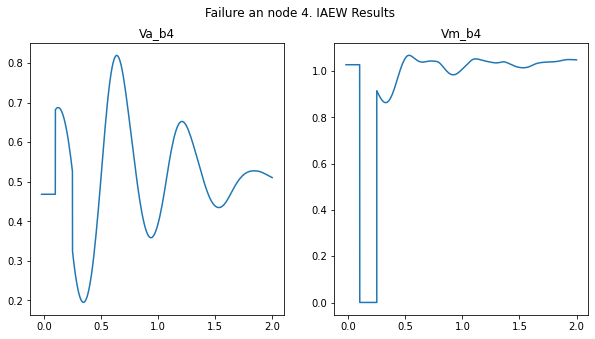

In [6]:
import scipy.io
import matplotlib.pyplot as plt

path_file = '/home/mmo-gog/dpsim/examples/Notebooks/9BusValidations/Originial_Static_Dynamic_Data_9Bus_System_incl_simulations.mat'
iaew_results = scipy.io.loadmat(path_file, simplify_cells= True)
iaew_time=iaew_results['res_dyn_only_SYN']['Time']
#Voltage at Node 
Va_b4=iaew_results['res_dyn_only_SYN']['Variables'][:,6]
Vm_b4=iaew_results['res_dyn_only_SYN']['Variables'][:,7]

#Plot Voltage at Node 4
fig1, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 5))
fig1.suptitle('Failure an node 4. IAEW Results')
ax1.plot(iaew_time, Va_b4)
ax2.plot(iaew_time, Vm_b4)
ax1.set_title('Va_b4')
ax2.set_title('Vm_b4')



Compare all Node Voltage and Generator Variables DPsim vs IAEW

column number: 22
results length: 2001
real column names: ['Gen_N1.Pe', 'Gen_N1.Pm', 'Gen_N1.w', 'Gen_N2.Pe', 'Gen_N2.Pm', 'Gen_N2.w', 'Gen_N3.Pe', 'Gen_N3.Pm', 'Gen_N3.w']
complex column names: ['N1.V', 'N10.V', 'N11.V', 'N12.V', 'N2.V', 'N3.V', 'N4.V', 'N5.V', 'N6.V', 'N7.V', 'N8.V', 'N9.V', 'gnd.V']


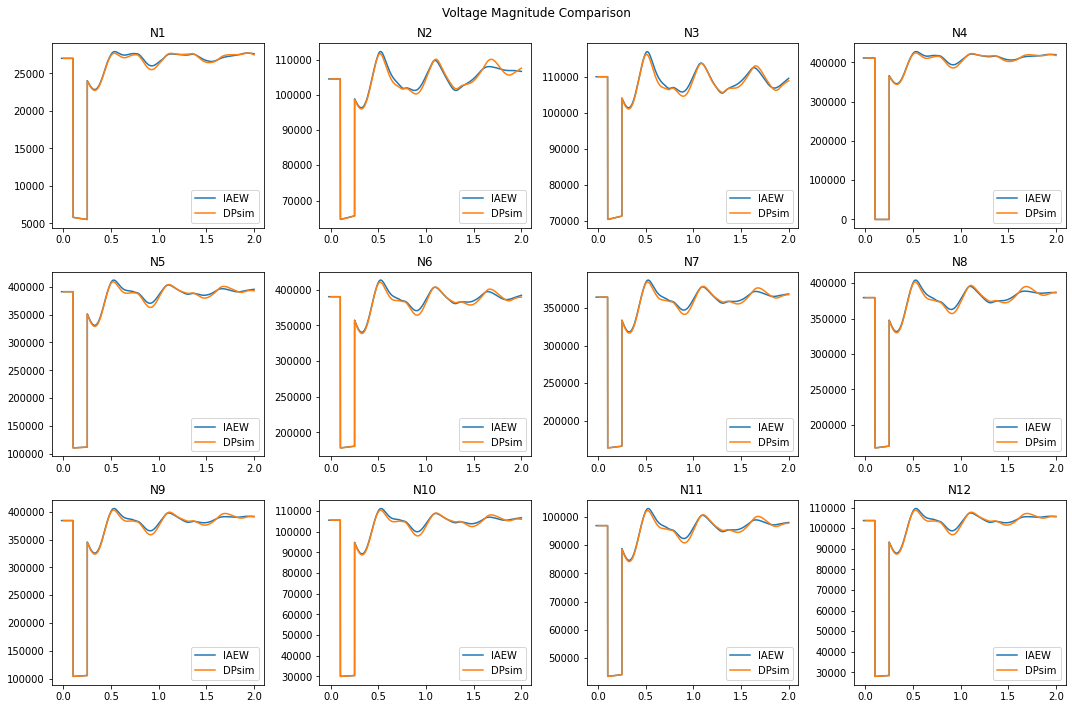

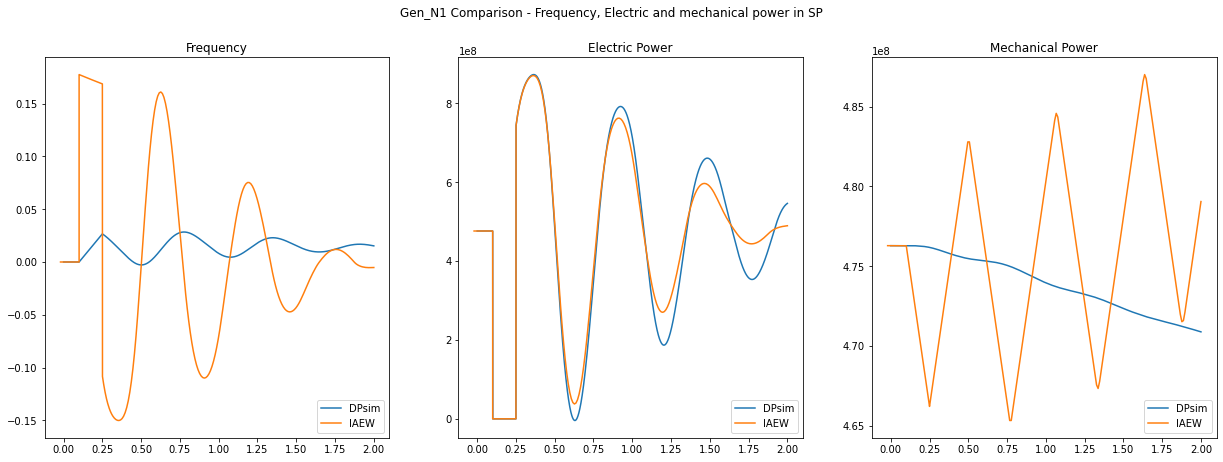

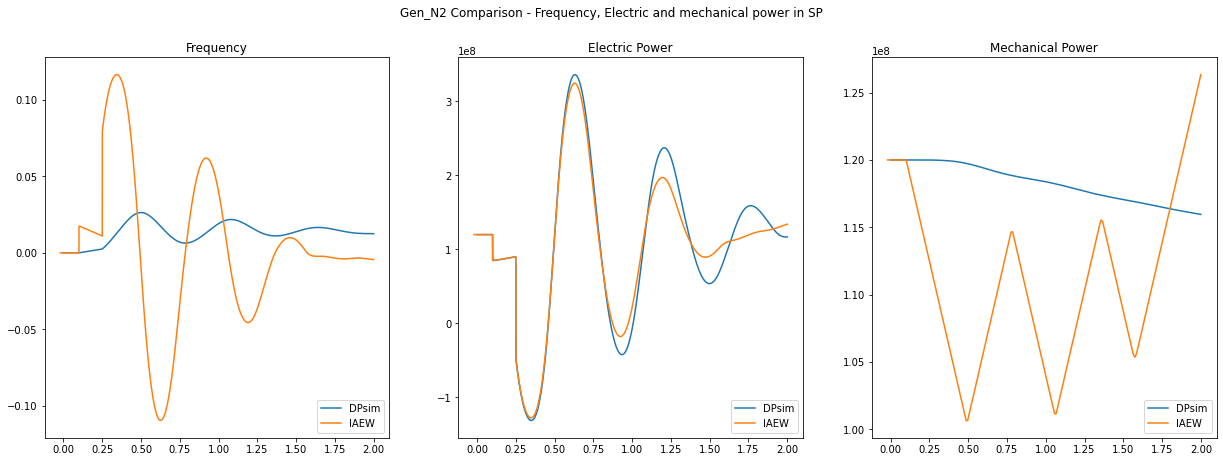

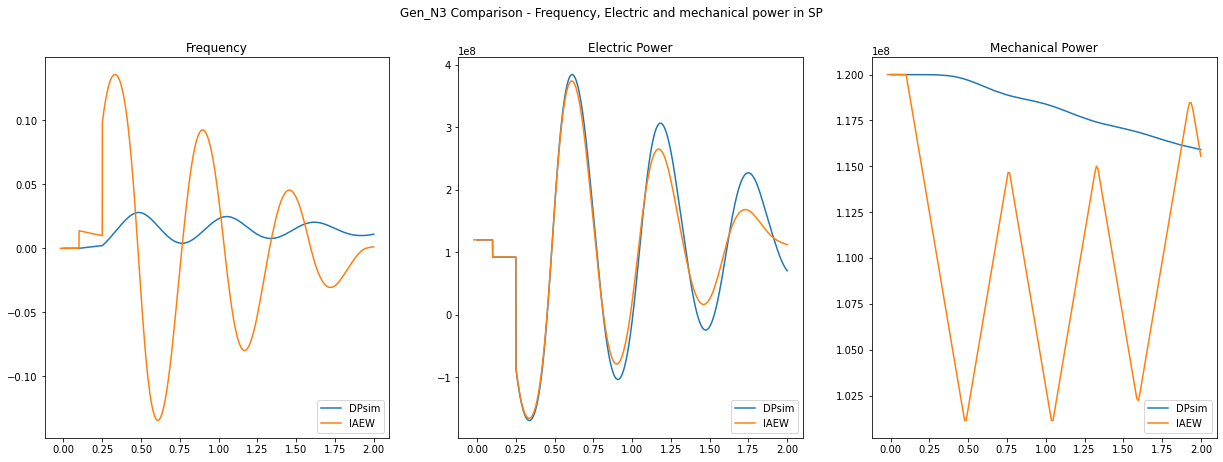

In [15]:
import scipy.io
import matplotlib.pyplot as plt

path_file = '/home/mmo-gog/dpsim/examples/Notebooks/9BusValidations/Originial_Static_Dynamic_Data_9Bus_System_incl_simulations.mat'
iaew_results = scipy.io.loadmat(path_file, simplify_cells= True)
iaew_time=iaew_results['res_dyn_only_SYN']['Time']

dpsim_result_file = 'logs/' + sim_name_dyn_sp + '/' + sim_name_dyn_sp + '.csv'
ts_dpsim_sp = read_timeseries_csv(dpsim_result_file)
phasors = ts.phasors(ts_dpsim_sp)

# iterator for angles, magnitude and bus
a = 0
m = 1
bus = 0
# Number of rows and columns for subplots
num_rows = 3
num_cols = 4

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
fig.suptitle('Voltage Magnitude Comparison')

for row in range(num_rows):
    for col in range(num_cols):
        node_name = f"N{row * num_cols + col + 1}"
        
        V_base = iaew_results['case9_static_only_SYN']['bus'][bus, 9] * 1e3
        angle = iaew_results['res_dyn_only_SYN']['Variables'][:, a]
        magnitude = iaew_results['res_dyn_only_SYN']['Variables'][:, m] * V_base

        # Plot on the corresponding subplot
        axes[row, col].plot(iaew_time, magnitude, label='IAEW')
        axes[row, col].plot(ts_dpsim_sp[node_name + '.V'].time, ts_dpsim_sp[node_name + '.V'].abs().values, label='DPsim')
        axes[row, col].set_title(node_name)
        axes[row, col].legend(loc='lower right')

        a = a + 2
        m = m + 2
        bus = bus + 1

plt.tight_layout()
plt.show()

#Plot the Generator frequency, mechanical and electrical power
iaew_raws_delomega = [78, 80, 82]
iaew_raws_Pe = [121, 122, 123]
iaew_raws_Pm = [26, 34, 42]
gen_baseS_dpsim=[6.708204e+08, 5.000000e+08, 5.000000e+08]

for gen_name, delomega_idx, Pe_idx, Pm_idx, baseS_idx in zip(["Gen_N1", "Gen_N2", "Gen_N3"], iaew_raws_delomega, iaew_raws_Pe, iaew_raws_Pm, gen_baseS_dpsim):
    # Plotting DPSim and IAEW results on the same subplot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7))
    fig.suptitle(gen_name + ' Comparison - Frequency, Electric and mechanical power in SP')

    # Plot DPSim results
    frequency_dpsim = ts_dpsim_sp[gen_name + '.w'].values-1
    Epower_dpsim = ts_dpsim_sp[gen_name + '.Pe'].values*baseS_idx
    Mpower_dpsim = ts_dpsim_sp[gen_name + '.Pm'].values*baseS_idx
    t_dpsim = ts_dpsim_sp[gen_name + '.Pe'].time
    ax1.plot(t_dpsim, frequency_dpsim, label='DPsim')
    ax2.plot(t_dpsim, Epower_dpsim, label='DPsim')
    ax3.plot(t_dpsim, Mpower_dpsim, label='DPsim')

    # Plot IAEW results
    frequency_iaew = iaew_results['res_dyn_only_SYN']['Variables'][:, delomega_idx]
    Epower_iaew = iaew_results['res_dyn_only_SYN']['Variables'][:, Pe_idx]*1000e6
    Mpower_iaew = iaew_results['res_dyn_only_SYN']['Variables'][:, Pm_idx]*1000e6
    ax1.plot(iaew_time, frequency_iaew, label='IAEW')
    ax2.plot(iaew_time, Epower_iaew, label='IAEW')
    ax3.plot(iaew_time, Mpower_iaew, label='IAEW')

    # Set titles for subplots
    ax1.set_title('Frequency')
    ax2.set_title('Electric Power')
    ax3.set_title('Mechanical Power')

    # Add legend to the subplots
    ax1.legend(loc='lower right')
    ax2.legend(loc='lower right')
    ax3.legend(loc='lower right')

plt.show()


DP dynamic simulation

In [ ]:
sim_name_dyn_dp = 'DP_only_SYN_case9_dyn'
dpsimpy.Logger.set_log_dir('logs/' + sim_name_dyn_dp)

mpc_reader = iaewreader.Reader(mpc_file_path=path_file, mpc_name='case9_static_only_SYN', 
                             mpc_dyn_file_path=path_file, mpc_dyn_name='case9_dyn_only_SYN')
mpc_reader.create_dpsim_objects(domain=iaewreader.Domain.DP, frequency=50, with_avr=True, with_tg=True, with_pss=True)
#create a switch
sw = dpsimpy.dp.ph1.Switch('Fault', dpsimpy.LogLevel.info)
switch_closed = 0.2
sw.set_parameters(1e18, switch_closed)
sw.open()
mpc_reader.dpsimpy_comp_dict['Fault'] = [sw]
#Node 11 is the load at 100kV, node 7 ist a node of 400kV grid, between Node 7 and 11 there is a transformer
mpc_reader.dpsimpy_comp_dict['Fault'].append([dpsimpy.dp.SimNode.gnd, mpc_reader.dpsimpy_busses_dict["N4"]])

# create dpsim topology
system_dyn = mpc_reader.create_dpsim_topology()

#initialize node voltages using pf results
system_dyn = mpc_reader.system
system_dyn.init_with_powerflow(system_pf)

logger = dpsimpy.Logger(sim_name_dyn_dp)
for node in system_dyn.nodes:
    logger.log_attribute(node.name()+'.V', 'v', node)
# Log electrical power and omega of SGs
for gen_name in ["Gen_N1", "Gen_N2", "Gen_N3"]:
    logger.log_attribute('{}.Pe'.format(gen_name), 'Te', mpc_reader.dpsimpy_comp_dict[gen_name][0])
    logger.log_attribute('{}.w'.format(gen_name), 'w_r', mpc_reader.dpsimpy_comp_dict[gen_name][0])
    
# Parametrize and run simulation
sim = dpsimpy.Simulation(sim_name_dyn_dp, dpsimpy.LogLevel.info)
sim.set_system(system_dyn)
sim.set_time_step(1e-4)
sim.set_final_time(2.5)
sim.set_domain(dpsimpy.Domain.DP)
sim.set_solver(dpsimpy.Solver.MNA)
sim.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.SparseLU)
sim.do_init_from_nodes_and_terminals(True)
sim.do_system_matrix_recomputation(True)
sim.add_logger(logger)

# add event
sw_event_1 = dpsimpy.event.SwitchEvent(0.1, sw, True)
sw_event_2 = dpsimpy.event.SwitchEvent(0.25, sw, False)
sim.add_event(sw_event_1)
sim.add_event(sw_event_2)

sim.run()

EMT dynamic Simulation

In [ ]:
sim_name_dyn_emt = 'EMT_only_SYN_case9_dyn'
dpsimpy.Logger.set_log_dir('logs/' + sim_name_dyn_emt)

# read and create dpsim topology
mpc_reader = iaewreader.Reader(mpc_file_path=path_file, mpc_name='case9_static_only_SYN', 
                             mpc_dyn_file_path=path_file, mpc_dyn_name='case9_dyn_only_SYN')
mpc_reader.create_dpsim_objects(domain=iaewreader.Domain.EMT, frequency=50, log_level=dpsimpy.LogLevel.info, 
                                 with_avr=False, with_tg=True, with_pss=True)

#Fault at node 11 is the load at 100kV, node 7 ist a node of 400kV grid, between Node 7 and 11 there is a transformer
sw = dpsimpy.emt.ph3.SeriesSwitch('Fault', dpsimpy.LogLevel.info)
switch_closed = 0.2
sw.set_parameters(1e18, switch_closed)
sw.open()
mpc_reader.dpsimpy_comp_dict['Fault'] = [sw]
mpc_reader.dpsimpy_comp_dict['Fault'].append([dpsimpy.emt.SimNode.gnd, mpc_reader.dpsimpy_busses_dict["N4"]])

# create dpsim topology
mpc_reader.create_dpsim_topology()

#initialize node voltages using pf results
system_dyn = mpc_reader.system
system_dyn.init_with_powerflow(system_pf, dpsimpy.Domain.EMT)

# log results
logger = dpsimpy.Logger(sim_name_dyn_emt)
for node in system_dyn.nodes:
    logger.log_attribute(node.name()+'.V', 'v', node)
# Log electrical power and omega of SGs
for gen_name in ["Gen_N1", "Gen_N2", "Gen_N3"]:
    logger.log_attribute('{}.Pe'.format(gen_name), 'Te', mpc_reader.dpsimpy_comp_dict[gen_name][0])
    logger.log_attribute('{}.w'.format(gen_name), 'w_r', mpc_reader.dpsimpy_comp_dict[gen_name][0])
     
# Parametrize and run simulation
sim = dpsimpy.Simulation(sim_name_dyn_emt, dpsimpy.LogLevel.debug)
sim.set_system(system_dyn)
sim.set_time_step(1e-4)
sim.set_final_time(2.5)
sim.set_domain(dpsimpy.Domain.EMT)
sim.set_solver(dpsimpy.Solver.MNA)
sim.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.SparseLU)
sim.do_init_from_nodes_and_terminals(True)
sim.do_system_matrix_recomputation(True)
sim.add_logger(logger)

# add events
sw_event_1 = dpsimpy.event.SwitchEvent(0.1, sw, True)
sw_event_2 = dpsimpy.event.SwitchEvent(0.25, sw, False)
sim.add_event(sw_event_1)
sim.add_event(sw_event_2)

sim.set_time_step(1e-4)
sim.run()

Read EMT und DP

In [ ]:
dpsim_result_file = 'logs/' + sim_name_dyn_dp + '/' + sim_name_dyn_dp + '.csv'
ts_dpsim_dp = read_timeseries_csv(dpsim_result_file)

dpsim_result_file = 'logs/' + sim_name_dyn_emt + '/' + sim_name_dyn_emt + '.csv'
ts_dpsim_emt = read_timeseries_csv(dpsim_result_file)

Definition of a Plot Function

In [ ]:
def plot_node_volt_abs(varname_dpsim, ts_dpsim_sp, ts_dpsim_dp, nominal_voltage, timestep_common):
   
    width = 12
    height = 4 
    t_begin = 0
    t_end = 40
    begin_idx = int(t_begin/timestep_common)
    end_idx= int(t_end/timestep_common)
    time = np.linspace(t_begin, t_end, num=end_idx-begin_idx)
    #convert dpsim voltage to magnitude value and per-unit for comparison with psat
    dpsim_sp_values_abs_pu = ts_dpsim_sp[varname_dpsim].interpolate(timestep_common).abs().values[begin_idx:end_idx]/nominal_voltage
    dpsim_dp_values_abs_pu = ts_dpsim_dp[varname_dpsim].interpolate(timestep_common).abs().values[begin_idx:end_idx]/nominal_voltage

    plt.figure(figsize=(width, height))
    #plt.plot(time, dpsim_dp_values_abs_pu, label='DP - DPsim')
    plt.plot(time, dpsim_sp_values_abs_pu, label='SP - DPsim')
    plt.legend(loc='lower right')
    plt.xlabel('time (s)')
    plt.grid()
    plt.xlim([0,40])
    plt.show()

In [ ]:
varname_dpsim = 'N4.V'
varname_psat = 'V_Bus04'
nominal_voltage = 400000
plot_node_volt_abs(varname_dpsim, ts_dpsim_sp, ts_dpsim_dp, nominal_voltage, 0.001)

In [ ]:
timestep_common = 1e-4
t_begin = 0
t_end = 2.5
begin_idx = int(t_begin/timestep_common)
end_idx= int(t_end/timestep_common)
time = np.linspace(t_begin, t_end, num=end_idx-begin_idx)

#plot parameters
width = 12
height = 4

varname_dpsim = 'N4.V_0'
nominal_voltage = 400000*math.sqrt(2/3) 

dpsim_dp_values = (ts_dpsim_emt[varname_dpsim].interpolate(timestep_common).values[begin_idx:end_idx]/nominal_voltage).real

plt.figure(figsize=(width, height))
plt.plot(time, dpsim_dp_values, label='EMT - DPsim')

plt.legend(loc='lower right')
plt.xlabel('time (s)')
plt.grid()
plt.ylim([-1.5, 1.5])
plt.xlim([0, 2.5])
plt.show()

In [ ]:
varname_dpsim = 'N4.V'
varname_psat = 'V_Bus04'
nominal_voltage = 400000
plot_node_volt_abs(varname_dpsim, ts_dpsim_sp, ts_dpsim_dp, nominal_voltage, timestep_common=0.0001)